In [2]:
using Pkg; Pkg.activate(".")

  Activating project at `~/experiments/cf`


In [3]:
using Revise
includet("mixing_length.jl")

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (4), incompatible header (10), dep missing source (2))
[ Info: Precompiling AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6] 
┌ Info: Skipping precompilation due to precompilable error. Importing AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
[ Info: Precompiling ClimaAtmos [b2c96348-7fb7-4fe0-8da9-78d88439e717] (cache misses: wrong dep version loaded (6), incompatible header (12))
[ Info: Precompiling RecursiveArrayToolsStructArraysExt [07510ace-05c5-59ac-8535-cc0df8d4a157] (cache misses: wrong dep version loaded (8), incompatible header (10))
[ Info: Precompiling SciMLBaseMakieExt [565f26a4-c902-5eae-92ad-e10714a9d9de] (cache misses: wrong dep version loaded (8), incompatible header (10))
[ Info: Precompiling Di

## Dev

In [6]:
mix_len, mix_len_no_z = compute_mixing_length(ds_profiles, ds_timeseries, params)

(ClimaAtmos.MixingLength{Float32}[ClimaAtmos.MixingLength{Float32}(0.027332691f0, 8.629264f0, 0.0f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.838308f0, 8.807261f0, 64.61138f0, 20.0f0) … ClimaAtmos.MixingLength{Float32}(8.383935f0, 8.365395f0, 69.21188f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.368324f0, 8.350131f0, 69.2388f0, 20.0f0); ClimaAtmos.MixingLength{Float32}(3.733875f-5, 19.769424f0, 0.0f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 20.235554f0, 57.838207f0, 40.0f0) … ClimaAtmos.MixingLength{Float32}(19.208103f0, 19.077742f0, 64.05938f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(19.165094f0, 19.037245f0, 64.67273f0, 40.0f0); … ; ClimaAtmos.MixingLength{Float32}(1.1920929f-7, 5947.598f0, 0.0f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 6111.6177f0, 108.38234f0, 3980.0f0) … ClimaAtmos.MixingLength{Float32}(20.0f0, 5703.0127f0, 108.525955f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 5688.472f0, 108.52624f0, 3980.0f0); ClimaAtmos.MixingLength{Float32}(1

In [20]:
# compute gradients
z = ds_profiles["z"][:]
thetali_gradient = compute_vertical_gradient(ds_profiles["thetali_mean"][:, :]', z)'
qt_gradient = compute_vertical_gradient(ds_profiles["qt_mean"][:, :]', z)';

In [16]:
# compute the normalization lengths
q_lengthscale = find_q_lengthscale(params, ds_profiles)

p_example = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][:, :] .* ds_profiles["temperature_mean"][:, :]
q_tot_example = ds_profiles["qt_mean"][:, :]
θ_lengthscale = find_thetali_lengthscale.(CAP.thermodynamics_params(params), p_example, q_tot_example);

200×865 Matrix{Float64}:
 285.684  286.28   286.506  286.633  …  285.942  285.949  285.974  285.962
 285.753  286.146  286.387  286.526     285.745  285.752  285.785  285.771
 285.833  286.1    286.338  286.48      285.675  285.673  285.709  285.693
 285.925  286.077  286.293  286.439     285.672  285.648  285.685  285.676
 286.031  286.101  286.269  286.417     285.733  285.691  285.724  285.724
 286.147  286.169  286.272  286.414  …  285.825  285.774  285.8    285.805
 286.27   286.268  286.311  286.431     285.934  285.877  285.894  285.904
 286.396  286.383  286.389  286.469     286.048  285.992  285.997  286.012
 286.522  286.506  286.495  286.533     286.163  286.111  286.107  286.123
 286.649  286.632  286.616  286.623     286.276  286.23   286.221  286.235
 286.777  286.759  286.742  286.733  …  286.387  286.348  286.338  286.347
 286.905  286.886  286.867  286.851     286.495  286.466  286.456  286.458
 287.033  287.012  286.99   286.97      286.601  286.583  286.572  286.567


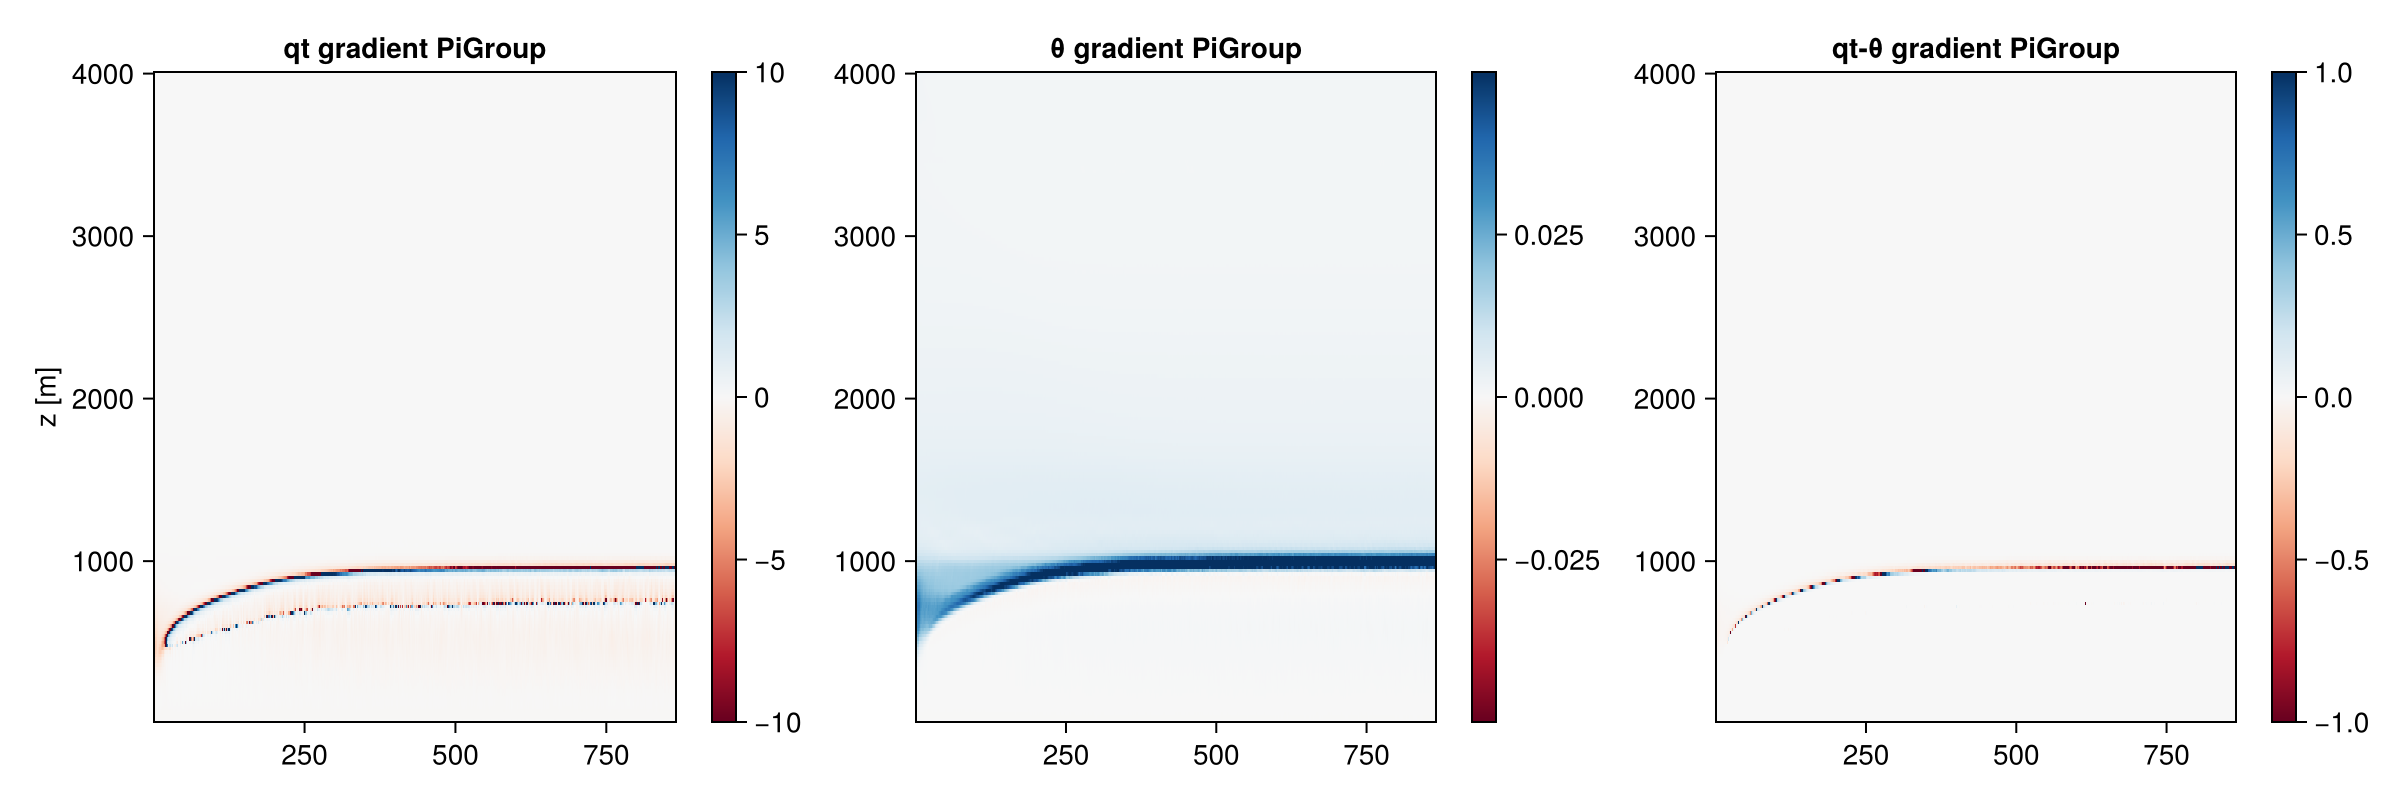

In [41]:
# assemble the predictors
gr1 = qt_gradient .* mix_len_no_z ./ q_lengthscale
gr2 = thetali_gradient .* mix_len_no_z ./ θ_lengthscale
gr3 = qt_gradient .* thetali_gradient .* mix_len_no_z .^2 ./ (q_lengthscale .* θ_lengthscale)

fig = Figure(size=(1200, 400))
ax1 = Axis(fig[1, 1], ylabel="z [m]", title="qt gradient PiGroup")
ax2 = Axis(fig[1, 3], title="θ gradient PiGroup")
ax3 = Axis(fig[1, 5], title="qt-θ gradient PiGroup")

# Plot heatmaps
t = 1:size(gr1, 2)
hm1 = heatmap!(ax1, t, z, gr1', colormap=:RdBu, colorrange = (-10, 10))
Colorbar(fig[1, 2], hm1)
hm2 = heatmap!(ax2, t, z, gr2', colormap=:RdBu, colorrange = (-.05, .05))
Colorbar(fig[1, 4], hm2)
hm3 = heatmap!(ax3, t, z, gr3', colormap=:RdBu, colorrange = (-1, 1))
Colorbar(fig[1, 6], hm3)

# Set y-axis to show height
# for ax in [ax1, ax2, ax3]
#     ax.yticks = (1:40:200, string.(round.(Int, z[1:40:200])))
# end

fig


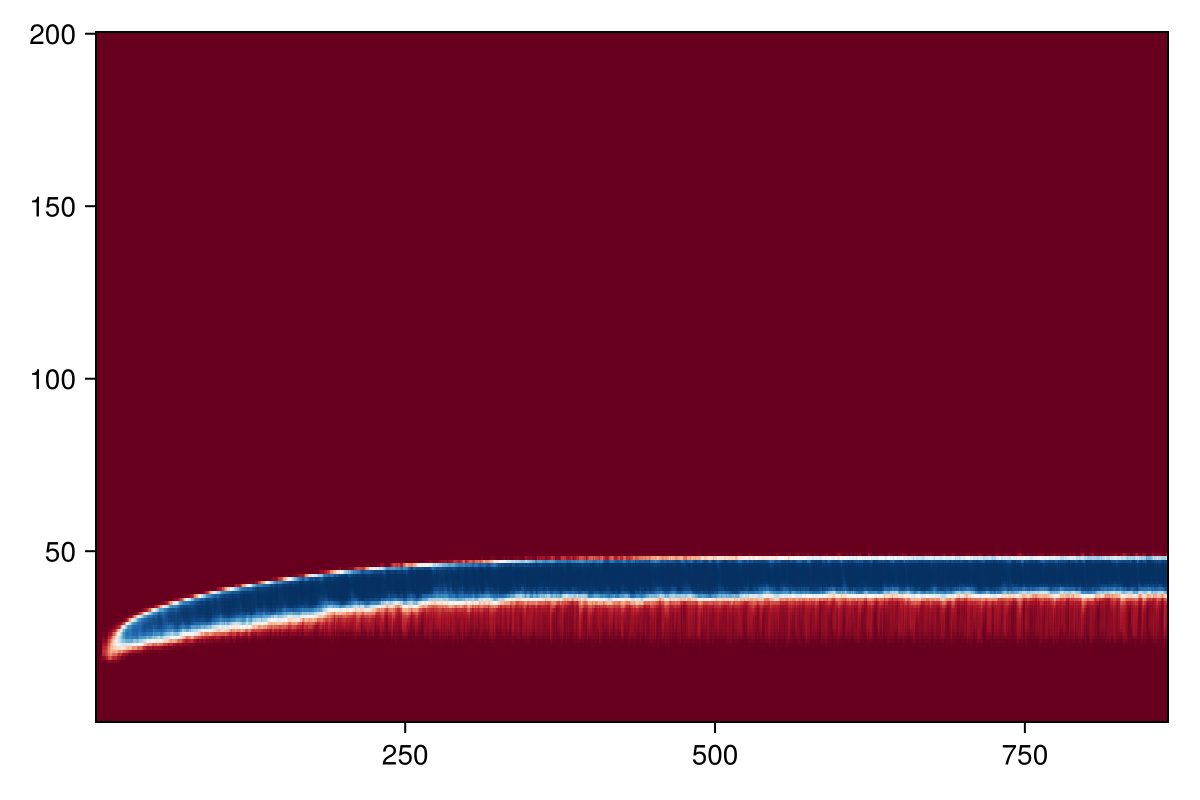

In [4]:
# get the target
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1])
heatmap!(ax, ds_profiles["cloud_fraction"][:, :]', colormap=:RdBu, colorrange = (0, 1))
fig


## ML

In [7]:
predictors = [
    "tke",
    "thetali_gradient",
    "gr3",
    "q_lengthscale",
    "buoyancy_freq",
    "gr2",
    "mix_len_no_z",
    "strain_rate",
    "theta_lengthscale",
    "gr1",
    "qt_gradient",
    "q_tot",
    "t"
]
target = "cloud_fraction"

sample_site_data = process_les_file(LES_DATA_PATH, params);
X, y = flatten_and_preprocess(sample_site_data, predictors, target)

df = DataFrame(X, predictors)
df[!, :cloud_fraction] = y;

## logistic Regression

Model Summary:
StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

cloud_fraction ~ 1 + q_lengthscale

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error       z  Pr(>|z|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)        0.627281   0.0230864   27.17    <1e-99      0.582032      0.672529
q_lengthscale  -7336.1       94.4782     -77.65    <1e-99  -7521.28      -7150.93
─────────────────────────────────────────────────────────────────────────────────────


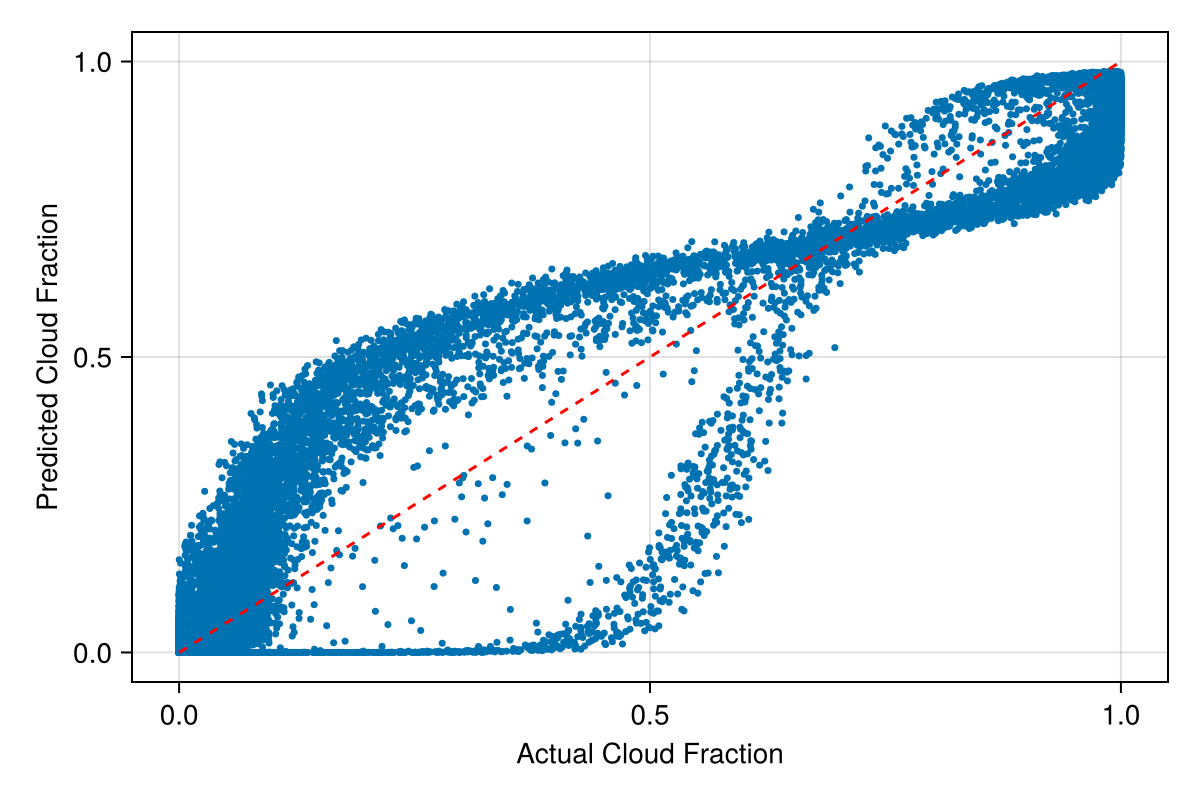

In [68]:
# Import required packages

# Convert data to DataFrame format
df = DataFrame(X, predictors)
df[!, :cloud_fraction] = y

# Fit linear regression model
# model = lm(@formula(cloud_fraction ~ tke + thetali_gradient + gr3 + q_lengthscale + 
#     buoyancy_freq + gr2 + mix_len_no_z + strain_rate + theta_lengthscale + gr1 + qt_gradient), df)
model = glm(@formula(cloud_fraction ~ q_lengthscale), df, Binomial())


# Print model summary
println("Model Summary:")
println(model)

# Make predictions
y_pred = predict(model, df)

# Calculate R² score
# r2_score = r2(model)
# println("\nR² score: ", r2_score)

# Plot actual vs predicted values
fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1], xlabel="Actual Cloud Fraction", ylabel="Predicted Cloud Fraction")
scatter!(ax, y, y_pred, markersize=5)
lines!(ax, [0, 1], [0, 1], color=:red, linestyle=:dash)  # Perfect prediction line
fig


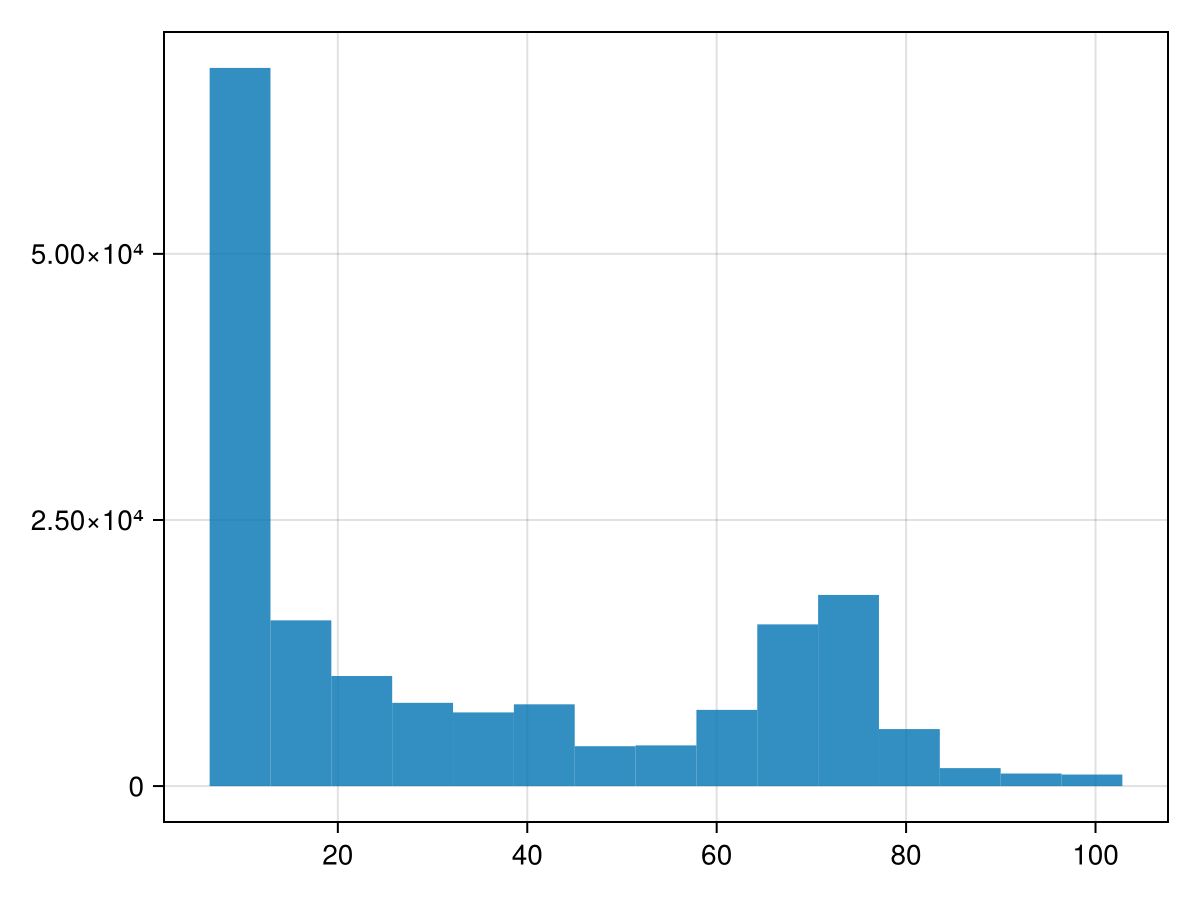

In [87]:
df = DataFrame(X, predictors)
df[!, :cloud_fraction] = y

hist(df[!, :tke])


## Random Forest

In [4]:
# lets come up with a nonlinear model 

# Convert data to DataFrame format
df = DataFrame(X, predictors)
df[!, :cloud_fraction] = y

# Split data into train/test sets
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=123)

# Define the Random Forest model
rf = @load RandomForestRegressor pkg=DecisionTree
rf_model = rf(
    n_trees=100,
    max_depth=10,
    min_samples_leaf=5
)

# Wrap model in machine
mach = machine(rf_model, df[train, predictors], df[train, :cloud_fraction])

# Train the model
fit!(mach)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJDecisionTreeInterface ✔


[ Info: Training machine(RandomForestRegressor(max_depth = 10, …), …).


trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = 10, …)
  args: 
    1:	Source @886 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @773 ⏎ AbstractVector{Continuous}


In [5]:
y_pred = predict_mode(mach, df[test, predictors])


34600-element Vector{Float64}:
 2.056992793574469e-5
 0.20964234661327874
 1.8040608921433143e-5
 2.056992793574469e-5
 2.056992793574469e-5
 0.0005357476579731907
 0.9901637816977187
 0.47661968348469097
 2.056992793574469e-5
 1.8040608921433143e-5
 1.9402713935323842e-5
 1.8040608921433143e-5
 2.056992793574469e-5
 ⋮
 2.056992793574469e-5
 2.056992793574469e-5
 2.056992793574469e-5
 0.000266472976040333
 0.00010550388495469277
 2.0649631673920044e-5
 2.056992793574469e-5
 2.0649631673920044e-5
 2.056992793574469e-5
 0.6921154990945702
 2.056992793574469e-5
 2.056992793574469e-5

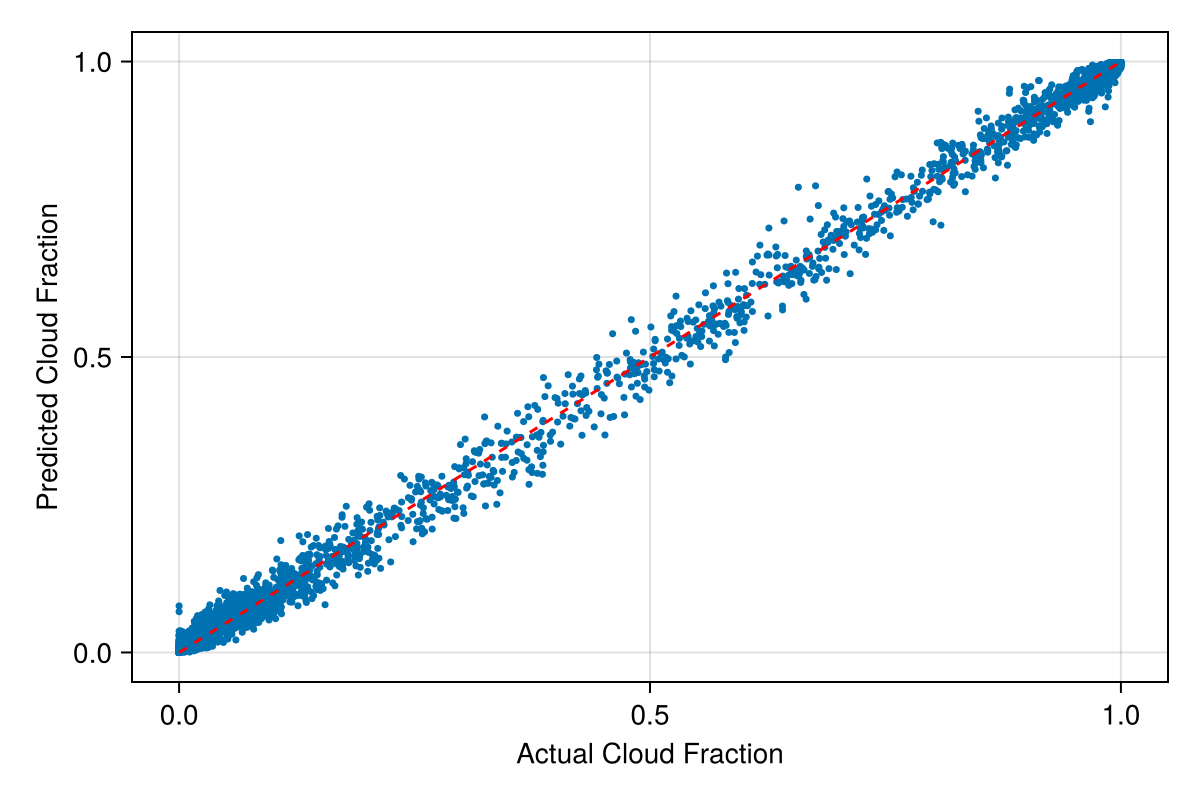

In [6]:

# Make predictions
y_pred = predict_mean(mach, df[test, predictors])

# # Calculate R² score
# r2_score = r2(y_pred, df[test, :cloud_fraction])
# println("R² score: ", r2_score)


# Plot results
fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1], xlabel="Actual Cloud Fraction", ylabel="Predicted Cloud Fraction")
scatter!(ax, df[test, :cloud_fraction], y_pred, markersize=5)
lines!(ax, [0, 1], [0, 1], color=:red, linestyle=:dash)  # Perfect prediction line
fig

# # Feature importance
# importance = feature_importances(rf_model, mach)
# println("\nFeature Importance:")
# for (feature, imp) in zip(predictors, importance)
#     println("$feature: $imp")
# end

In [ ]:
using Flux, ProgressMeter, Statistics

n_features = length(predictors)
n_hidden = 64

# Create neural network model - removed sigmoid, using linear output
nn_model = Chain(
    Dense(n_features, n_hidden, relu),
    BatchNorm(n_hidden),  # Add BatchNorm to help with training
    Dense(n_hidden, n_hidden, relu),
    BatchNorm(n_hidden),
    Dense(n_hidden, 1)    # Linear output layer, no activation
)

# 1. Prepare data for Flux
# Flux expects features as rows and samples as columns
X_train = Matrix(df[train, predictors])'
y_train = reshape(df[train, :cloud_fraction], 1, :)

# Scale features to help with training
using Statistics
feature_means = mean(X_train, dims=2)
feature_stds = std(X_train, dims=2)
X_train_scaled = (X_train .- feature_means) ./ feature_stds

# 2. Define optimizer and setup state
opt_state = Flux.setup(Flux.Adam(0.001), nn_model)

# 3. Create a data loader for batching
loader = Flux.DataLoader((X_train_scaled, y_train), batchsize=64, shuffle=true)

# 4. Training loop with clamping
losses = []
@showprogress "Training..." for epoch in 1:100
    batch_losses = []
    for (x_batch, y_batch) in loader
        loss, grads = Flux.withgradient(nn_model) do m
            # Get raw predictions and clamp to [0,1]
            y_hat = clamp.(m(x_batch), 0.0f0, 1.0f0)
            Flux.mse(y_hat, y_batch)
        end
        Flux.update!(opt_state, nn_model, grads[1])
        push!(batch_losses, loss)
    end
    push!(losses, mean(batch_losses))
    
    # Print progress every 10 epochs
    if epoch % 10 == 0
        println("Epoch $epoch: Loss = $(losses[end])")
    end
end

# Evaluate on training data
X_test = Matrix(df[test, predictors])'
X_test_scaled = (X_test .- feature_means) ./ feature_stds
y_test = reshape(df[test, :cloud_fraction], 1, :)

y_pred_test = clamp.(nn_model(X_test_scaled), 0.0f0, 1.0f0)
test_mse = Flux.mse(y_pred_test, y_test)
println("\nTest MSE: $test_mse")

# Plot distribution of predictions vs true values
using CairoMakie
fig = Figure(size=(800, 400))

# Histogram of predictions vs true values
ax1 = Axis(fig[1, 1], 
    xlabel="Cloud Fraction",
    ylabel="Count",
    title="Distribution of Predictions vs True Values")

hist!(ax1, vec(y_pred_test), bins=50, alpha=0.5, label="Predictions")
hist!(ax1, vec(y_test), bins=50, alpha=0.5, label="True Values")
axislegend()

# Scatter plot of predicted vs true values
ax2 = Axis(fig[1, 2],
    xlabel="True Cloud Fraction",
    ylabel="Predicted Cloud Fraction",
    title="Predicted vs True Values")

scatter!(ax2, vec(y_test), vec(y_pred_test), alpha=0.3)
lines!(ax2, [0, 1], [0, 1], color=:red, linestyle=:dash)  # Perfect prediction line

fig


In [108]:
sqrt(mean((y_pred - df[test, :cloud_fraction]).^2))

0.006414602793361347

## Neural Network 

In [4]:
# Define neural network architecture
n_features = length(predictors)
n_hidden = 64

# Create neural network model
nn_model = Chain(
    Dense(n_features, n_hidden, relu),
    Dropout(0.2),
    Dense(n_hidden, n_hidden, relu),
    Dropout(0.2),
    Dense(n_hidden, 1, sigmoid)  # sigmoid for output between 0 and 1
)

# Wrap in MLJFlux regressor
# NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg=MLJFlux
nn_regressor = NeuralNetworkRegressor(
    builder=nn_model,
    optimiser=ADAM(0.001),
    epochs=100,
    batch_size=64,
    lambda=0.01,  # L2 regularization
    alpha=0.5,    # L1 regularization
    rng=123
)

opt_state = Flux.setup(Flux.Adam(0.01), nn_regressor)

# Create and train machine
loader = Flux.DataLoader((df[train, predictors], df[train, :cloud_fraction]), batchsize=64, shuffle=true);
mach = machine(nn_regressor, df[train, predictors], df[train, :cloud_fraction])
@showprogressfor epoch in 1:100
    Flux.train!(mach, loader, opt_state) do m, x, y
        y_hat = m(x)
        Flux.logitcrossentropy(y_hat, y)
    end
end

# fit!(mach)


# # Make predictions
# y_pred = predict(mach, df[test, predictors])

# # Plot results
# fig = Figure(size=(600, 400))
# ax = Axis(fig[1, 1], xlabel="Actual Cloud Fraction", ylabel="Predicted Cloud Fraction")
# scatter!(ax, df[test, :cloud_fraction], y_pred, markersize=5)
# lines!(ax, [0, 1], [0, 1], color=:red, linestyle=:dash)  # Perfect prediction line
# fig

# # Calculate R² score
# r2_score = r2(y_pred, df[test, :cloud_fraction])
# println("R² score: ", r2_score)


LoadError: UndefVarError: `df` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Rmath in the current active module Main

In [19]:
n_features = length(predictors)
n_hidden = 64

train, test = partition(eachindex(y), 0.8, shuffle=true, rng=123)


# Create neural network model
nn_model = Chain(
    Dense(n_features, n_hidden, relu),
    Dropout(0.2),
    Dense(n_hidden, n_hidden, relu),
    Dropout(0.2),
    Dense(n_hidden, 1, sigmoid)  # sigmoid for output between 0 and 1
)

# --- Pure Flux Training ---
using Flux, ProgressMeter, Statistics

# 1. Prepare data for Flux
# Flux expects features as rows and samples as columns.
# DataFrame has samples as rows, so we need to transpose.
X_train = Matrix(df[train, predictors])'
y_train = reshape(df[train, :cloud_fraction], 1, :) # Target as a 1xN row matrix

# 2. Define optimizer and setup state
opt_state = Flux.setup(Flux.Adam(0.001), nn_model)

# 3. Create a data loader for batching
loader = Flux.DataLoader((X_train, y_train), batchsize=64, shuffle=true)

# 4. Training loop
losses = []
@showprogress "Training..." for epoch in 1:100
    for (x_batch, y_batch) in loader
        loss, grads = Flux.withgradient(nn_model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x_batch)
            Flux.logitcrossentropy(y_hat, y_batch) # Mean Squared Error for regression
        end
        Flux.update!(opt_state, nn_model, grads[1])
        push!(losses, loss)  # log loss for this batch
    end
end

println("Training finished.")
# You can plot losses to see how training went, for example with:
# using Plots
# plot(losses, yaxis=:log)

Training... 100%|████████████████████████████████████████| Time: 0:00:38


Training finished.


In [21]:
X_test

13×34600 adjoint(::Matrix{Float64}) with eltype Float64:
  37.9322       77.3241        6.98391     …    7.39895       19.1679
   0.00897284    0.191065      0.00356613       0.00393909     0.00681367
  -8.87998e-5   -0.285576     -3.10893e-6      -5.65813e-7    -2.38701e-5
   0.0154696     0.00132985    0.00943651       0.0127276      0.0152992
   7.66564e-8    3.14976e-5    1.15953e-8       1.47074e-8     4.33181e-8
   0.00526205    0.059588      0.00131423  …    0.0012589      0.00298263
 163.453        90.2318      106.662           90.5964       121.867
   0.00473465    0.0316899     0.0020471        0.00300614     0.00430392
 278.719       289.322       289.425          283.476        278.399
  -0.0168755    -4.7925       -0.00236559      -0.000449451   -0.00800302
  -1.59714e-6   -7.06328e-5   -2.09286e-7  …   -6.31417e-8    -1.0047e-6
   0.00254718    0.00742648    0.00115359       0.00130856     0.00170701
 293.925       283.708       281.098          286.938        291.86

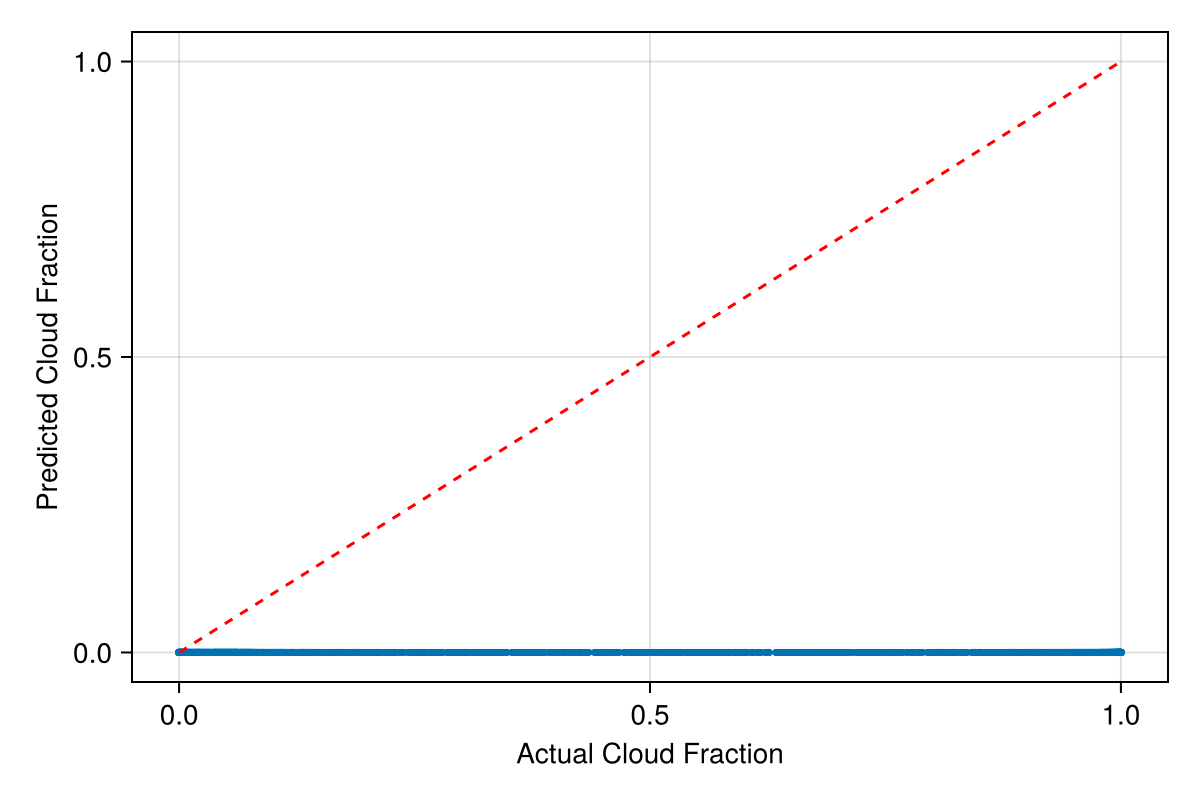

In [20]:
X_test = Matrix(df[test, predictors])'
y_test = reshape(df[test, :cloud_fraction], 1, :) # Target as a 1xN row matrix

y_test_pred = nn_model(X_test)
fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1], xlabel="Actual Cloud Fraction", ylabel="Predicted Cloud Fraction")
scatter!(ax, y_test[:], y_test_pred[:], markersize=5)
lines!(ax, [0, 1], [0, 1], color=:red, linestyle=:dash)  # Perfect prediction line
fig


In [ ]:

## Neural Network (Improved Regression)

using Flux, ProgressMeter, Statistics

n_features = length(predictors)
n_hidden = 64

# Create neural network model - removed sigmoid, using linear output
nn_model = Chain(
    Dense(n_features, n_hidden, relu),
    BatchNorm(n_hidden),  # Add BatchNorm to help with training
    Dense(n_hidden, n_hidden, relu),
    BatchNorm(n_hidden),
    Dense(n_hidden, 1)    # Linear output layer, no activation
)

# 1. Prepare data for Flux
# Flux expects features as rows and samples as columns
X_train = Matrix(df[train, predictors])'
y_train = reshape(df[train, :cloud_fraction], 1, :)

# Scale features to help with training
using Statistics
feature_means = mean(X_train, dims=2)
feature_stds = std(X_train, dims=2)
X_train_scaled = (X_train .- feature_means) ./ feature_stds

# 2. Define optimizer and setup state
opt_state = Flux.setup(Flux.Adam(0.001), nn_model)

# 3. Create a data loader for batching
loader = Flux.DataLoader((X_train_scaled, y_train), batchsize=64, shuffle=true)

# 4. Training loop with clamping
losses = []
@showprogress "Training..." for epoch in 1:100
    batch_losses = []
    for (x_batch, y_batch) in loader
        loss, grads = Flux.withgradient(nn_model) do m
            # Get raw predictions and clamp to [0,1]
            y_hat = clamp.(m(x_batch), 0.0f0, 1.0f0)
            Flux.mse(y_hat, y_batch)
        end
        Flux.update!(opt_state, nn_model, grads[1])
        push!(batch_losses, loss)
    end
    push!(losses, mean(batch_losses))
    
    # Print progress every 10 epochs
    if epoch % 10 == 0
        println("Epoch $epoch: Loss = $(losses[end])")
    end
end

# Evaluate on training data
X_test = Matrix(df[test, predictors])'
X_test_scaled = (X_test .- feature_means) ./ feature_stds
y_test = reshape(df[test, :cloud_fraction], 1, :)

y_pred_test = clamp.(nn_model(X_test_scaled), 0.0f0, 1.0f0)
test_mse = Flux.mse(y_pred_test, y_test)
println("\nTest MSE: $test_mse")



Training...   9%|███▋                                    |  ETA: 0:04:18

Epoch 10: Loss = 0.00048373345019357114


Training...  19%|███████▋                                |  ETA: 0:02:34

Epoch 20: Loss = 0.0003202998602508346


Training...  29%|███████████▋                            |  ETA: 0:01:54

Epoch 30: Loss = 0.00021923043019627923


Training...  39%|███████████████▋                        |  ETA: 0:01:29

Epoch 40: Loss = 0.0001995598766767845


Training...  49%|███████████████████▋                    |  ETA: 0:01:11

Epoch 50: Loss = 0.00018436119041591724


Training...  59%|███████████████████████▋                |  ETA: 0:00:54

Epoch 60: Loss = 0.00017607538116652668


Training...  69%|███████████████████████████▋            |  ETA: 0:00:40

Epoch 70: Loss = 0.00017166077053550361


Training...  79%|███████████████████████████████▋        |  ETA: 0:00:27

Epoch 80: Loss = 0.00015442472099574695


Training...  89%|███████████████████████████████████▋    |  ETA: 0:00:14

Epoch 90: Loss = 0.00015250238553660275


Training...  99%|███████████████████████████████████████▋|  ETA: 0:00:01

Epoch 100: Loss = 0.00014316534423621592


Training... 100%|████████████████████████████████████████| Time: 0:02:02



Test MSE: 0.00025583973627747925


LoadError: Invalid attribute [31m[1malpha[22m[39m for plot type [34m[1mPlot{Makie.hist, Tuple{Vector{Float32}}}[22m[39m.

The available plot attributes for Plot{Makie.hist, Tuple{Vector{Float32}}} are:

bar_labels  fillto          label_formatter  over_background_color  weights
bins        flip_labels_at  label_offset     over_bar_color                
color       gap             label_size       scale_to                      
cycle       label_color     normalization    strokecolor                   
direction   label_font      offset           strokewidth                   



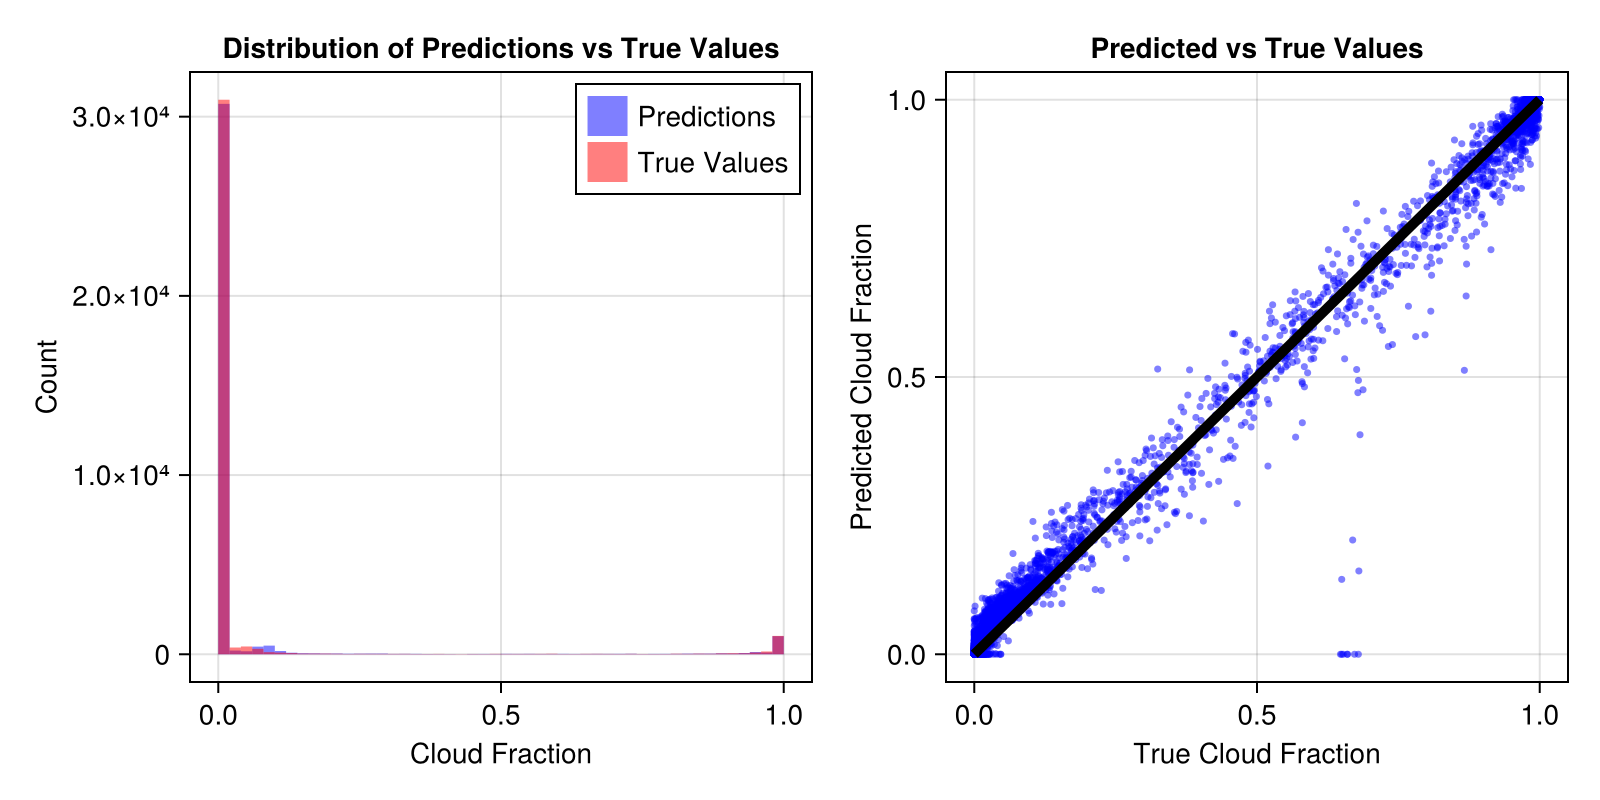

In [28]:
# Plot distribution of predictions vs true values
using CairoMakie
fig = Figure(size=(800, 400))

# Histogram of predictions vs true values
ax1 = Axis(fig[1, 1], 
    xlabel="Cloud Fraction",
    ylabel="Count",
    title="Distribution of Predictions vs True Values")

hist!(ax1, vec(y_pred_test), bins=50, color = (:blue, 0.5), label="Predictions")
hist!(ax1, vec(y_test), bins=50, color = (:red, 0.5), label="True Values")
axislegend()

# Scatter plot of predicted vs true values
ax2 = Axis(fig[1, 2],
    xlabel="True Cloud Fraction",
    ylabel="Predicted Cloud Fraction",
    title="Predicted vs True Values")

scatter!(ax2, vec(y_test), vec(y_pred_test), color = (:blue, 0.5), markersize = 5)
lines!(ax2, [0, 1], [0, 1], color=(:black, 1), linestyle=:solid, linewidth = 5)  # Perfect prediction line

fig

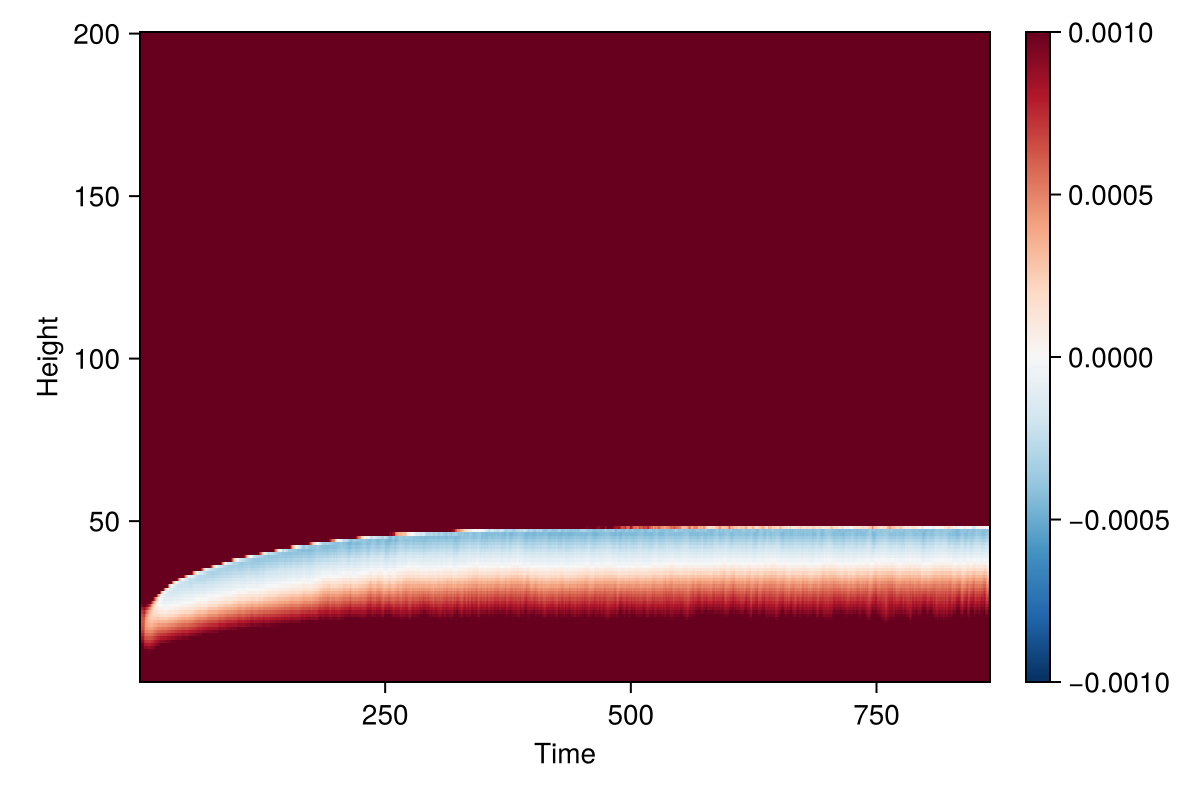

In [ ]:
using Revise
includet("mixing_length.jl")
LES_DATA_PATH


z = ds_profiles["z"][:]
t = ds_profiles["t"][:]

# unpack variables 
t = ds_profiles["temperature_mean"][:, :]
buoyancy_freq = ds_profiles["buoyancy_frequency_mean2"][:, :]
strain_rate = ds_profiles["strain_rate_magnitude"][:, :]
qt = ds_profiles["qt_mean"][:, :]
thetali = ds_profiles["thetali_mean"][:, :]
cloud_fraction = ds_profiles["cloud_fraction"][:, :]


mix_len, mix_len_no_z = compute_mixing_length(ds_profiles, ds_timeseries, params)

thetali_gradient = compute_vertical_gradient(ds_profiles["thetali_mean"][:, :]', z)'
qt_gradient = compute_vertical_gradient(ds_profiles["qt_mean"][:, :]', z)'

tke_data = tke(ds_profiles)


# sat_hus = TD.q_vap_saturation.(CA.Parameters.thermodynamics_params(params), 
#                     ds_profiles["temperature_mean"][:, :], 
#                     1 ./ ds_profiles["alpha_mean"][:, :], 
#                     TD.PhaseEquil)

# humidity_deficit = sat_hus .- qt







# fig = Figure(size=(600, 400))
# ax = Axis(fig[1, 1], xlabel="Time", ylabel="Height")
# hm = heatmap!(ax, humidity_deficit', colormap=reverse(cgrad(:RdBu)), colorrange=(-0.001, 0.001))
# Colorbar(fig[1, 2], hm)
# fig

In [7]:
function get_les_site_names()
    pattern = "../../../../net/sampo/data1/zhaoyi/GCMForcedLES/cfsite/*/HadGEM2-A/amip/Output.cfsite*_HadGEM2-A_amip_2004-2008.*.4x/stats/Stats.cfsite*_HadGEM2-A_amip_2004-2008.*.nc"
    return Glob.glob(pattern)
end

site_names = get_les_site_names();

In [12]:
idx = 2
tprof = NCDataset(site_names[idx]).group["profiles"]
tseries = NCDataset(site_names[idx]).group["timeseries"]

Dataset: ../../../../net/sampo/data1/zhaoyi/GCMForcedLES/cfsite/01/HadGEM2-A/amip/Output.cfsite10_HadGEM2-A_amip_2004-2008.01.4x/stats/Stats.cfsite10_HadGEM2-A_amip_2004-2008.01.nc
Group: profiles

Dimensions
   z = 200
   t = 865

Variables
  z   (200)
    Datatype:    Float64 (Float64)
    Dimensions:  z

  z_half   (200)
    Datatype:    Float64 (Float64)
    Dimensions:  z

  t   (865)
    Datatype:    Float64 (Float64)
    Dimensions:  t

  thetas_mean   (200 × 865)
    Datatype:    Float64 (Float64)
    Dimensions:  z × t
    Attributes:
     units                = None
     nice_name            = None
     description          = None

  thetas_mean2   (200 × 865)
    Datatype:    Float64 (Float64)
    Dimensions:  z × t
    Attributes:
     units                = None
     nice_name            = None
     description          = None

  thetas_mean3   (200 × 865)
    Datatype:    Float64 (Float64)
    Dimensions:  z × t
    Attributes:
     units                = None
     nice_n